## Load and Clean Data

In [1]:
import pickle

In [2]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt  

Using TensorFlow backend.


In [5]:
reddit = pd.read_json("./data_1000.json")

In [6]:
reddit.comments = [x[:200] for x in reddit.comments]

In [7]:
lst_col_ga = 'comments'

df = reddit

reddit = pd.DataFrame({
     col:np.repeat(df[col].values, df[lst_col_ga].str.len())
     for col in df.columns.drop(lst_col_ga)}
   ).assign(**{lst_col_ga:np.concatenate(df[lst_col_ga].values)})[df.columns].dropna().reset_index(drop = True)

In [8]:
reddit.comments = [x.replace("\n", '').replace("\t", '') for x in reddit.comments]
reddit.title = [x.replace("\n", '').replace("\t", '') for x in reddit.title]

In [9]:
reddit.comments = [x[:200] for x in reddit.comments]
reddit.title = [x[:200] for x in reddit.title]

In [10]:
reddit.iloc[260][1]

'Having a bad mental health day, not liking what I see in the mirror Really need some positive'

In [11]:
reddit[['comments', 'title']].to_csv('reddit.csv', sep="\t", header=False, index=False)

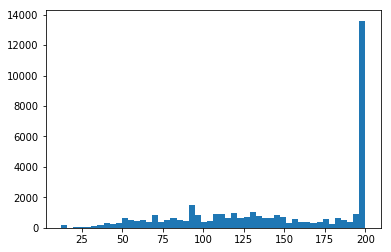

In [12]:
plt.hist([len(i) for i in reddit.title], bins=50)
plt.show()

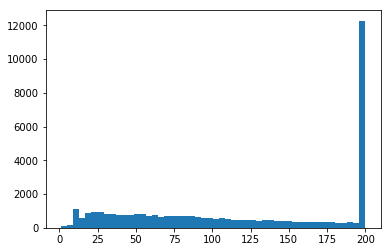

In [13]:
plt.hist([len(i) for i in reddit.comments], bins=50)
plt.show()

In [14]:
len(reddit)

39446

In [15]:
plt.scatter([i for i in range(len(comm_len))], comm_len)

NameError: name 'comm_len' is not defined

In [16]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			#store as string
			clean_pair.append(' '.join(line))
		if len(clean_pair) == 2:
			cleaned.append(clean_pair)
	return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = './reddit.csv'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[i dont even know what to say rtoastme community you have all blown my mind and touched my heart when i posted this i was just sharing little bit of myself and didnt expect much response cause t] => [i wanted to share a big milestone for me when i was deep in my depression for over a decade i had planned to disappear and quietly commit suicide at age i battled depression and found reasons to]
[happy birthday i love your smile] => [i wanted to share a big milestone for me when i was deep in my depression for over a decade i had planned to disappear and quietly commit suicide at age i battled depression and found reasons to]
[happy birthday congratulations on making it to this huge milestone you must be a very strong determined person to have overcome this depression is so hard to deal with and anyone who comes out al] => [i wanted to share a big milestone for me when i was deep in my depression for over a decade i had planned to disappear and quietly commit sui

# Load, Reduce, and Split Clean Data

In [17]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# # save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
#n_sentences = 4963
dataset =  raw_dataset #[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:33000], dataset[33000:]
print(len(train), len(test))
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

33000 6446
Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


## Train

In [4]:
VOCAB_SIZE = 300

In [5]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt  
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm_notebook

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer(num_words=VOCAB_SIZE)
	tokenizer.fit_on_texts(lines)
	print(len(tokenizer.word_index))
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
tokenizer = create_tokenizer(dataset[:, 0:2].ravel())
vocab_size = tokenizer.num_words + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % vocab_size)
print('German Max Length: %d' % (ger_length))

23306
English Vocabulary Size: 301
English Max Length: 47
German Vocabulary Size: 301
German Max Length: 45


In [2]:
import os
GLOVE_DIR = "./"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [6]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((tokenizer.num_words+1, EMBEDDING_DIM))
for word, i in [i for i in tokenizer.word_index.items()][:tokenizer.num_words]:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [7]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in tqdm_notebook(sequences):
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
#     y = np.empty((0, len(sequences[0]), vocab_size), int)
#     for sequence in tqdm_notebook(sequences):
#         encoded = to_categorical(sequence, num_classes=vocab_size)
#         y = np.append(y, np.array([encoded]), axis=0)
#     print(y.shape)
#     assert y.shape == (sequences.shape[0], sequences.shape[1], vocab_size)
#     return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
#     cnn = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
    
    model = Sequential()
    #model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model





In [8]:
# prepare training data
trainX = encode_sequences(tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, vocab_size)
print(trainX.shape, trainY.shape)

# prepare validation data
testX = encode_sequences(tokenizer, ger_length, test[:, 1])
testY = encode_sequences(tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, vocab_size)
print(testX.shape, testY.shape)


(33000, 45) (33000, 47, 301)



(6446, 45) (6446, 47, 301)


In [9]:
# define model
model = define_model(vocab_size, vocab_size, ger_length, eng_length, 300)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 300)           90300     
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 47, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 47, 300)           721200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 47, 301)           90601     
Total params: 1,623,301
Trainable params: 1,533,001
Non-trainable params: 90,300
_________________________________________________________________
None


In [ ]:
#plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=0)


Epoch 00001: val_loss improved from inf to 2.03991, saving model to model.h5

Epoch 00002: val_loss improved from 2.03991 to 2.03039, saving model to model.h5

Epoch 00003: val_loss improved from 2.03039 to 2.02611, saving model to model.h5


# Evaluation

In [8]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources[:100]):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 20:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, tokenizer, testX, test)

C:\Users\morod\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:55: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if 'order' in inspect.getargspec(np.copy)[0]:


train
src=[i wanted to share a big milestone for me when i was deep in my depression for over a decade i had planned to disappear and quietly commit suicide at age i battled depression and found reasons to], target=[you absolutely epic champ keep it up and keep inspiring others thank you], predicted=[happy birthday you]
src=[feeling kinda down but i knew reddit would be able to help], target=[you look like the type of guy that walks into a room and everyone just smiles because youre there how can you not kind hearted eyes a sweet smile and the color of your hair is stunning that crisp white shirt surely means you have a meeting with success good luck to you], predicted=[you look like]
src=[tomorrow im going to court against my rapist and could really use some words of encouragement], target=[youre a legit hero], predicted=[you are you you]
src=[over the past years or so ive gained about pounds every time i manage to lose some weight i quickly put them back on its really effected how i 

C:\Users\morod\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.000007
BLEU-2: 0.000003
BLEU-3: 0.000001
BLEU-4: 0.000000
test
src=[after years of avoidance i am finally dealing with the fact that i am a victim of childhood sexual abuse and rape as an adult currently feeling dirty worthless and hopelessly depressed], target=[dont fall into a spiral of blaming your problems on these past injustices you are still responsible for improving the quality of your own life], predicted=[you are you you you you you]
src=[im going to a party soon and honestly i feel like shit and might end up not going maybe a toast will help], target=[low key archie andrews], predicted=[you look like]
src=[just a sad lonely year old who looks like shes and hides her insecurities beneath a smile i could do with some toasting], target=[its okay to have insecurities just dont let them control your life youre cute and youll have guys wanting to come into your life so i dont think youll have to do this alone], predicted=[you are]
src=[my gf of year cheated and confessed

In [14]:
t = ['I am depressed']
source = encode_sequences(tokenizer, 45, t)
prediction = model.predict(source, verbose=0)[0]
print(prediction.shape)
integers = [argmax(vector) for vector in prediction]
target = list()
for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
        break
    target.append(word)
' '.join(target)

(91, 401)


'you are'

## Questions

### How much effort is put into data preparation vs. actually training and evaluating the model?
In the the tutorial that we followed, not too much effort was put into data preparation. Most of the effort was simply lowercasing, removing punctuation, removing non-printable characters, and removing numbers. We could do a lot more of data preparation by trying to lemmatize/stem, finding POS tags, getting the dependency parsing, and more. Training and evaluating the model takes the bulk of the effort in this tutorial, as we need to worry about how to create the model and using the BLEU score to evaluate it. 

### What constitutes the input features? What constitutes the top layer?
The input features are made up of tokenized German words. Each word in an example is converted into an arbitrary list of numbers by the Keras Tokenizer. The output is also a list of tokenized words, but these words are in English and then they are also one-hot encoded so they work with the softmax in the model. 

### What does it mean that this is a "generative" classifier? How is that different from a discriminative classifier?
A generative classifier creates output based on both the input data and the previous outputs of the model. This is necessary for our LSTM because it has to generate word w based on word w-1, which it also predicted. A discriminative classifer generates output only based on the input data, and 

### How do you know your model works? What does a BLEU metric tell you? Can you think of a better way to evaluate MT output?
I know that my model works based on the BLEU metrics. This metric tells me how closely the predicted translation matches the target translation. This is not an exact match score, but it gives credit for a translation that is mostly the same. The higher the BLEU score, the better the predicted translation matches the target translation. There are different BLEU metrics for the different n-grams (BLEU-1, BLEU-2, etc). 

In [5]:
from client.api.notebook import Notebook
ok = Notebook('a8.ok')
ok.auth(inline=True)

Assignment: A8 Machine Translation with Keras
OK, version v1.13.11

Successfully logged in as DanieleMoro@u.boisestate.edu


In [6]:
ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'A8-machine-translation-keras.ipynb'.
Submit... 0.0% complete
Could not submit: Assignment does not exist

